In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from models.Resnet50_multiply import resnet50_multiply
from tensorflow.keras.utils import plot_model
from IPython.display import Image

Model: "Resnet50_multiply"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________

In [2]:
img_size = 64
batch_size = 20

In [3]:
# 先把根目錄用到food11
import os
# load dataset
dataset_dir = './food11'
# create new dir
try:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(11):
        os.mkdir(f'train/{i:02d}')
        os.mkdir(f'valid/{i:02d}')
except:
    pass

In [4]:
# create new file structure for dataset
for sub_dir in ['training', 'validation', 'test']:
    target_dir = os.path.join(dataset_dir, sub_dir)
    img_list = os.listdir(target_dir)
    for img_name in img_list:
        category, *r = img_name.split('_')
        img_path = os.path.join(target_dir, img_name)
        if len(r) == 0:
            new_fn = f'{sub_dir}/{img_name}'
        else:
            category = int(category)
            new_fn = f'{sub_dir[:5]}/{category:02d}/{img_name}'
    # resize image
        os.rename(img_path, new_fn)

In [5]:
# Dataset preprocessing
import tensorflow as tf
valid_data_pro = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #image augmentation
train_data = train_data_aug.flow_from_directory(
        'train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="sparse")
valid_data = valid_data_pro.flow_from_directory(
        'valid',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="sparse")
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    image_size=(img_size, img_size),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
test_set = test_set.map(lambda x: (tf.divide(x, 255)))

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 files belonging to 1 classes.


In [6]:
model = resnet50_multiply()
model.summary()
plot_model(model, to_file='models\ResNet50_multiply.png', show_shapes=True)
##調整學習率，採用學習率隨epoch數上升呈遞減的狀態，避免一開始學習過慢，之後overshooting的情形
starter_learning_rate = 1e-2
end_learning_rate = 1e-3
decay_steps = 3000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=0.6, cycle=True)
model_dir=r'.\models\Resnet50_multiply'
os.makedirs(model_dir)
log_dir = os.path.join('exam','model_3')
model_cbk=keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp=keras.callbacks.ModelCheckpoint(model_dir + '/Best_exam_model_3.h5', monitor='val_sparse_categorical_accuracy',save_best_only=True,mode='max')
model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
##根據林益帆同學發現的結果，改用遷移學習，準確率可顯著提升
history_1=model.fit(train_data,epochs=30,validation_data=valid_data,callbacks=[model_cbk,model_mckp])

Model: "Resnet50_multiply"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 32, 32, 64)   256         conv2d_58[0][0]                  
__________________________________________________________________________________

Epoch 1/30
494/494 [==============================] - 91s 160ms/step - loss: 38.4509 - sparse_categorical_accuracy: 0.1450 - val_loss: nan - val_sparse_categorical_accuracy: 0.1458
Epoch 2/30
494/494 [==============================] - 77s 156ms/step - loss: 37.3066 - sparse_categorical_accuracy: 0.1482 - val_loss: nan - val_sparse_categorical_accuracy: 0.1455
Epoch 3/30
494/494 [==============================] - 77s 155ms/step - loss: 36.6858 - sparse_categorical_accuracy: 0.1557 - val_loss: nan - val_sparse_categorical_accuracy: 0.1822
Epoch 4/30
494/494 [==============================] - 77s 155ms/step - loss: 36.1834 - sparse_categorical_accuracy: 0.1659 - val_loss: nan - val_sparse_categorical_accuracy: 0.1560
Epoch 5/30
494/494 [==============================] - 77s 156ms/step - loss: 35.7834 - sparse_categorical_accuracy: 0.1675 - val_loss: nan - val_sparse_categorical_accuracy: 0.1735
Epoch 6/30
494/494 [==============================] - 77s 157ms/step - loss: 35.4794 - sparse_c

In [7]:
model.load_weights('models\Resnet50_multiply\Best_exam_model_3.h5')
answer = model.predict(test_set)
df = pd.DataFrame()
df["Id"] = ["0"*(4-len(str(i)))+str(i) for i in range(1,np.shape(answer)[0]+1)]
def get_class(i):
    top_1_index = np.argsort(answer[i])[10]
    return top_1_index 
df["Category"] = [get_class(i) for i in range(0,np.shape(answer)[0])]
df.to_csv("test_result\submission_3.csv",index = False)

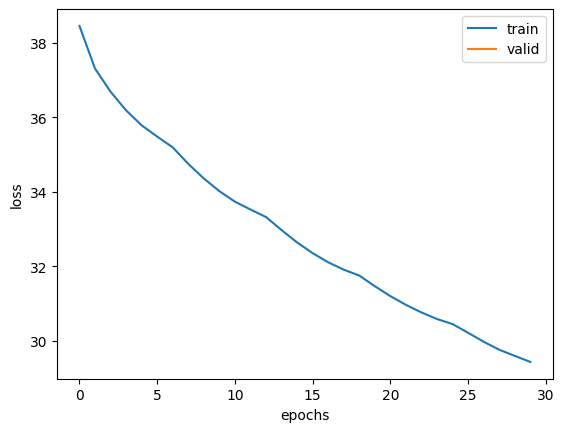

In [15]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='valid')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

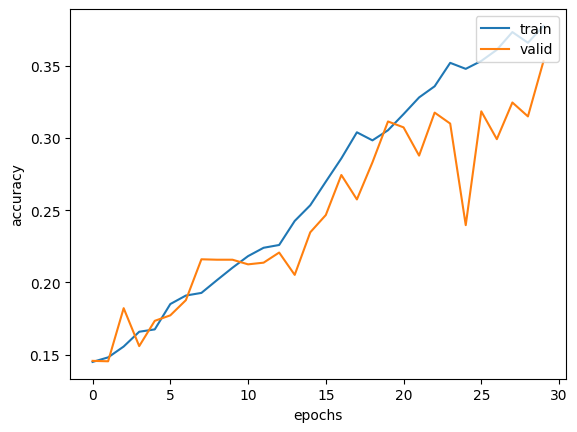

In [16]:
plt.plot(history_1.history['sparse_categorical_accuracy'], label='train')
plt.plot(history_1.history['val_sparse_categorical_accuracy'], label='valid')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

上述兩圖可見雖然loss持續降低，但是準確度隨著epochs增加，反而出現震盪的情況，顯示出有過擬合的情況發生

此模型為根據第三種residual block (global average + multiply)創建的ResNet 50精簡版(避免參數太多run out of GPU)，預測的準確度只有36.1%，和根據第一種residual block (只有經典的res_identity和res_conv)創建的ResNet 50精簡版相比(預測的準確度有43%)，反而預測的準確度還略低。暗示
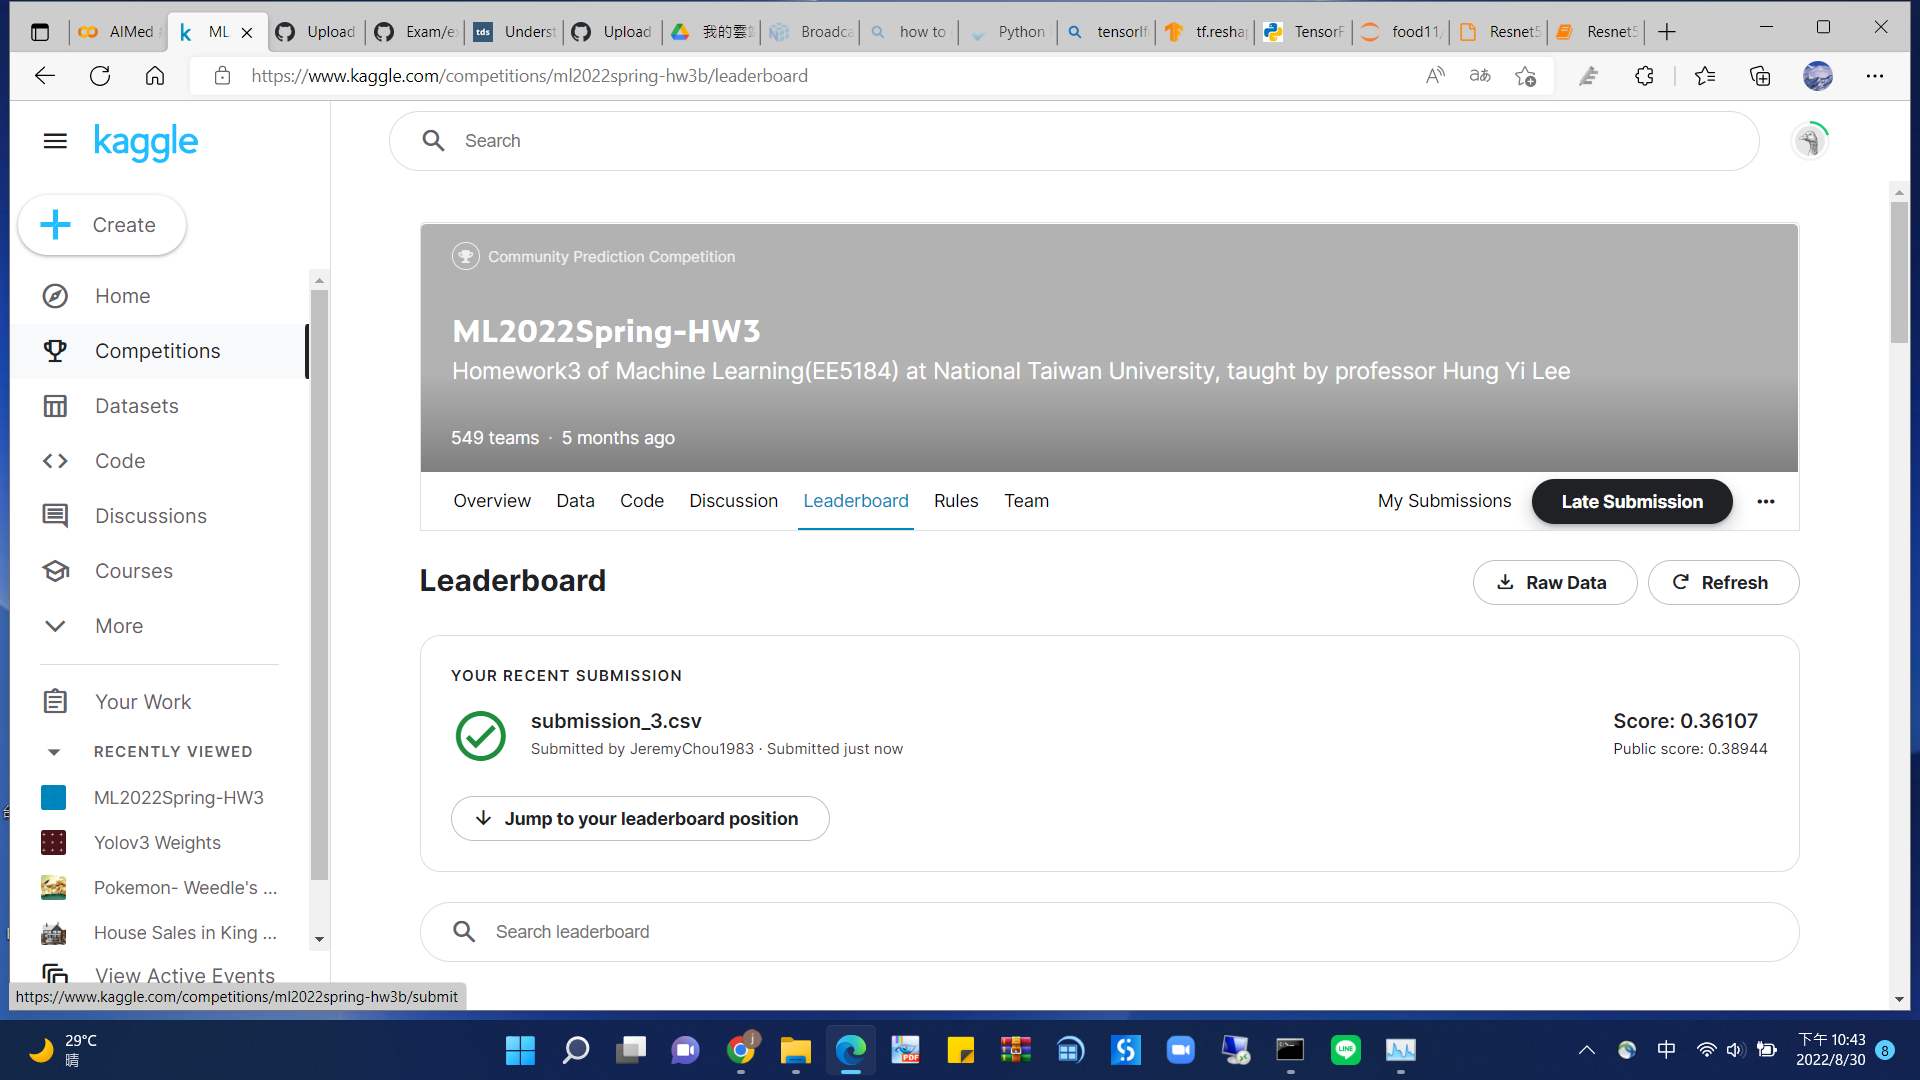